# BoardGameGeek Review Score Prediction: Machine Learning (JT)

Objective: To predict a user's review score based on their comments using machine learning

In [39]:
!pip install matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.3/7.3 MB 5.4 MB/s eta 0:00:0000:0100:01
  Using cached Pillow-9.2.0-cp39-cp39-macosx_10_10_x86_64.whl (3.1 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.5/65.5 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.3/241.3 kB 4.7 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 960.0/960.0 kB 4.1 MB/s eta 0:00:0000:0100:01
  Using cached cycler-0.11.0-py3-none-any.whl (6.4 kB)


In [96]:
# imports
import pandas as pd
import numpy as np
import string
from string import digits
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_validate
from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt

# Read data

In [2]:
df = pd.read_csv('../data/clean_data.csv')
df.head(3)

,Unnamed: 0.1,Unnamed: 0,user,rating,comment,ID,name
0,4108284,4108284,PegasusGamesNYC,2.0,Played it once and didn't like it,9209,Ticket to Ride
1,9412682,9412682,captaincomic,4.0,Several things to dislike: Player elimination;...,24068,Shadow Hunters
2,3448962,3448962,jblomquist,4.0,Seems like an ok game but it doesn't really wo...,150376,Dead of Winter: A Crossroads Game


In [3]:
df.shape

(100000, 7)

In [4]:
# Filter df
df = df[['rating','comment']]
df.head()

,rating,comment
0,2.0,Played it once and didn't like it
1,4.0,Several things to dislike: Player elimination;...
2,4.0,Seems like an ok game but it doesn't really wo...
3,3.0,Flux and Munchkin mixed but worse. Way way way...
4,3.0,The game open the player to be sieged by group...


# Check DF for nulls, duplicates

In [5]:
df.isnull().sum()

rating     0
comment    0
dtype: int64

No nulls

In [6]:
df[df.duplicated()]

,rating,comment
1042,3.0,I don't like trivia games. There are certain ...
1256,3.0,jack
1925,4.0,Kids
1993,1.0,Beware of BGG's incorrect data on this game.
2404,3.0,2-6
...,...,...
99895,5.0,Will comment and rate later!
99949,9.0,Painted
99953,6.0,
99963,8.0,Steam


In [7]:
df = df.drop_duplicates()

In [8]:
df.shape

(97885, 2)

DF reduced by 2115 rows from duplicates

In [9]:
df['rating'].value_counts()

4.0     24409
8.0     13559
3.0     12968
7.0     11863
6.0     10485
2.0      7353
9.0      5286
5.0      4354
1.0      4114
10.0     3492
0.0         2
Name: rating, dtype: int64

Ratings are clean

# Text preprocesing

In [109]:
# function to process text
stop_words = set(stopwords.words("english")) 
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = text.lower() # change to lower case
    text = text.rstrip() # remove right white space
    text = text.lstrip() # remove left white space
    text = text.translate(str.maketrans('', '', string.punctuation)) # remove puncutation
    text = text.translate(str.maketrans('', '', digits)) # remove numbers
    text = (text.encode('ascii', errors='ignore')).decode() # remove non english characters
    text = [lemmatizer.lemmatize(token) for token in text.split(" ")] # split sentence into tokens and lemmatize
    lemmatized = [lemmatizer.lemmatize(word, pos = 'n') for word in text] # Lemmatize
    lemmatized = [lemmatizer.lemmatize(word, pos = 'v') for word in lemmatized] # Lemmatize
    lemmatized = [lemmatizer.lemmatize(word, pos = 'a') for word in lemmatized] # Lemmatize
    lemmatized = [lemmatizer.lemmatize(word, pos = 'r') for word in lemmatized] # Lemmatize
    words_only = [word for word in lemmatized if word.isalpha()] # remove non alpha chars, incl. punctuation
    text = [word for word in words_only if not word in stop_words] # remove stop words
    text = " ".join(text) # join words back into a sentence
    return text


In [110]:
df['comment_pp'] = df['comment'].apply(lambda x: clean_text(x))

In [111]:
df.sample(3)

,rating,comment,comment_pp
40284,2.0,You feel like being played. Doesn't feel like ...,feel like play doesnt feel like make meaningfu...
40448,4.0,"I was going to give this a 4, then I saw that ...",wa go give saw munchikin quest wa mean insult ...
56249,8.0,My 6 year old's new favourite game!,year old new favourite game


In [112]:
df.shape

(97885, 3)

# Reduce categories of y into three

In [113]:
labels1 = ['Bad','Average','High']
df['y'] = pd.qcut(df['rating'],q=3, labels=labels1)

In [114]:
df.sample(3)

,rating,comment,comment_pp,y
65501,7.0,"Cool theme, neat mechanics. Probably not balan...",cool theme neat mechanic probably balance anyt...,Average
9997,1.0,Euro,euro,Bad
46613,4.0,Don't understand the hype. Just like San Juan....,dont understand hype like san juan space rathe...,Bad


In [156]:
df.y.value_counts()/len(df)

Bad        0.499014
Average    0.272789
High       0.228196
Name: y, dtype: float64

# Model

In [116]:
y = df['y']
X = df['comment_pp']

In [118]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [119]:
X_train.size

78308

In [120]:
X_train.sample(3)

46268    kwanchais redesign dont know feel yet may go l...
12684                   rather play resistance rather game
59004    seem best interaction game casual gamers even ...
Name: comment_pp, dtype: object

## Vectorize words

In [24]:
# vectorize words
vectorizer = TfidfVectorizer(ngram_range=(1,1))

In [25]:
train_vectors = pd.DataFrame(vectorizer.fit_transform(X_train).toarray(),
                 columns = vectorizer.get_feature_names_out())

In [26]:
train_vectors

,aa,aaaaa,aaaaaaaaaaaaaaaaarrrrrrrrrgggggggggggggghhhhhhhhhhhhhhhhhhhhhh,aaaaaaaaaaaarrrrrrrrrrrrggggggggggggggghhhhhhhhhhhhhhhh,aaaaaaah,aaaaaaand,aaaaaages,aaaaaagggghhhhhhhh,aaaaaall,aaaaaand,...,zzzzz,zzzzzz,zzzzzzz,zzzzzzzz,zzzzzzzzz,zzzzzzzzzz,zzzzzzzzzzzzz,zzzzzzzzzzzzzzzzzzzzzz,zzzzzzzzzzzzzzzzzzzzzzz,zzzzzzzzzzzzzzzzzzzzzzzzz
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75927,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75928,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75929,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75930,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Model with multinomial NB

In [28]:
model = MultinomialNB(alpha=0.05)
model.fit(train_vectors, y_train)

MultinomialNB(alpha=0.05)

In [29]:
model.classes_

array(['Average', 'Bad', 'High'], dtype='<U7')

In [30]:
model.score(train_vectors,y_train)

0.7369356792919981

In [31]:
# check metrics
cv_results = cross_validate(model, train_vectors, y_train, cv = 5, scoring = ["accuracy"])
cv_results['test_accuracy'].mean()

0.5926224541113255

## Learning curves to check for over/underfitting

In [152]:
X_vectorized = vectorizer.fit_transform(X)

In [153]:
X_vectorized.shape

(97885, 72399)

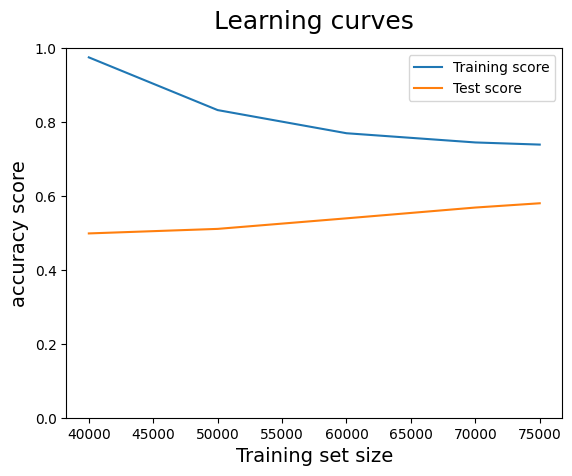

In [155]:
from sklearn.model_selection import learning_curve

# Get train scores, train sizes, and validation scores using `learning_curve`
train_sizes, train_scores, test_scores = learning_curve(
    estimator = MultinomialNB(alpha=0.05),
    X = X_vectorized, 
    y = y, 
    train_sizes =[40000,50000,60000,70000,75000], 
    cv = 5, scoring='accuracy'
)

# Take the mean of cross-validated train scores and validation scores
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

# Plot the learning curves!
plt.plot(train_sizes, train_scores_mean, label = 'Training score')
plt.plot(train_sizes, test_scores_mean, label = 'Test score')
plt.ylabel('accuracy score', fontsize = 14)
plt.xlabel('Training set size', fontsize = 14)
plt.title('Learning curves', fontsize = 18, y = 1.03)
#plt.xlim([0, 1000])
plt.ylim([0, 1])
plt.legend();

Model initially starts by overfitting (high variance ) - it is not able to generalise on new data.  Around 60000 iterations the lines begin to converge - potentiallyl underfitting a bit. The only hyper-parameter in NB is alpha → Higher alpha will give us almost the same probabilities → which is underfitting and lower alpha values will make the model underfit. 

There is a gap between training and test lines - perhaps the train data set does not represent the test set. To improve this in the future, to use a more representative dataset across target y and increase data.

## Tune parameters

In [52]:
# Pipeline vectorizer + Naive Bayes
pipeline_naive_bayes = make_pipeline(TfidfVectorizer(), 
                                     MultinomialNB())

# Cross-validation to check metrics
cv_results = cross_validate(pipeline_naive_bayes, X_train, y_train, cv = 5, scoring = ["accuracy"])
average_accuracy = cv_results["test_accuracy"].mean()
np.round(average_accuracy,2)

0.54

In [55]:
vectorizer.get_params()

{'analyzer': 'word',
 'binary': False,
 'decode_error': 'strict',
 'dtype': numpy.float64,
 'encoding': 'utf-8',
 'input': 'content',
 'lowercase': True,
 'max_df': 1.0,
 'max_features': None,
 'min_df': 1,
 'ngram_range': (1, 1),
 'norm': 'l2',
 'preprocessor': None,
 'smooth_idf': True,
 'stop_words': None,
 'strip_accents': None,
 'sublinear_tf': False,
 'token_pattern': '(?u)\\b\\w\\w+\\b',
 'tokenizer': None,
 'use_idf': True,
 'vocabulary': None}

In [59]:
from sklearn.model_selection import GridSearchCV

# Define the grid of parameters
parameters = {
    'tfidfvectorizer__ngram_range': ((1,1),(1,2), (2,2)),
    'tfidfvectorizer__min_df': (0, 0.01,0.01, 0.02),
    'multinomialnb__alpha': (0.25,0.05,0.1),}

# Perform Grid Search
grid_search = GridSearchCV(pipeline_naive_bayes,parameters, scoring = "accuracy",
                           cv = 5, n_jobs=-1, verbose=1)

grid_search.fit(X_train,y_train)

# Best score
print(f"Best Score = {grid_search.best_score_}")

# Best params
print(f"Best params = {grid_search.best_params_}")

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best Score = 0.6072933919696459
Best params = {'multinomialnb__alpha': 0.05, 'tfidfvectorizer__min_df': 0, 'tfidfvectorizer__ngram_range': (1, 2)}


## Update NB model with best params

In [69]:
pipe = make_pipeline(TfidfVectorizer(ngram_range=(1,2)), 
                                     MultinomialNB(alpha=0.05))


pipe.fit(X_train,y_train)

# Make predictions
y_pred = pipe.predict(X_test)


In [67]:
# Score model
pipe.score(X_test,y_test)

0.6146228402865571

In [70]:
from sklearn.metrics import accuracy_score
# Check metrics of y_pred
acc = accuracy_score(y_pred, y_test)
print('Range Accuracy on Multinomial Naive Bayes : {} %'.format(acc*100))

Range Accuracy on Multinomial Naive Bayes : 61.46228402865571 %


# Use model

In [141]:
# test model
print(X_test.iloc[0:1])
print(pipe.predict(['tight atmosphere g!od']))

58364    tight atmosphere good combination different me...
Name: comment_pp, dtype: object
['High']


In [146]:
def user_input(text):
    X = clean_text(text)
    print(f' Predicted rating: {pipe.predict([X])[0]}')

In [147]:
# Bad rating attempt
user_input('It was a rubbish game. Hated it')

 Predicted rating: Bad


In [148]:
# Good rating attempt
user_input('It was wonderful game!!!!! Top notch. Loved it ::::::)!')

 Predicted rating: High


In [149]:
# Average rating attempt
user_input('So so, nothing special. It was ok. ')

 Predicted rating: Average
